In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Load your dataset
df = pd.read_csv('gas_compressor_dataset_2.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

# Drop unnecessary columns
#df = df.drop(columns=['Unnamed: 0'], errors='ignore')

df.isnull().sum() * 100 / len(df)
df.describe()


,Suction_Pressure_PSIG,Discgarge_Pressure_PSIG,Temprature_C,Vibration_mms,Folw_Rate_m3h,Motor_Current_A,Runtime_Hours
count,220293.000000,143303.000000,220301.000000,210112.000000,220299.000000,219951.000000,220304.000000
mean,43.094984,183.049260,73.396414,2.372221,376.860041,47.591611,796.225942
std,12.837520,65.258650,17.298247,0.412227,113.206382,3.296666,226.679317
min,26.331018,27.488426,0.000000,0.000000,32.409550,0.000000,95.527660
25%,36.747684,167.534700,69.976260,2.438831,418.103250,46.310760,875.464400
50%,40.219910,193.865700,75.576790,2.456539,420.106200,48.133678,879.697600
75%,44.849540,219.907400,80.912150,2.499826,420.997100,49.479160,882.129900
max,320.312500,1000.000000,99.999880,2.549016,500.000000,56.727430,1107.526000


In [27]:
df = df.interpolate(method='linear')
df.isnull().sum().sum()

<ipython-input-27-1b5a3ccd72d1>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


np.int64(0)

Text(0.5, 1.0, 'Feature Correlation Matrix')

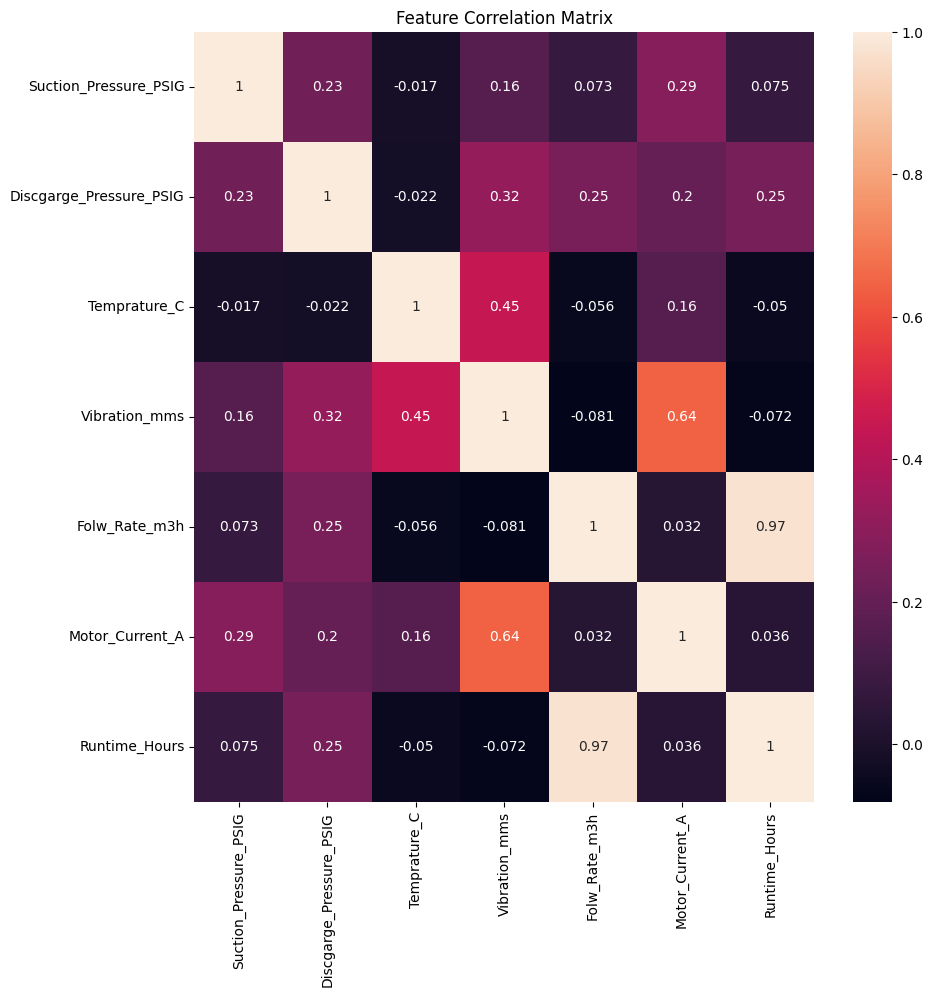

In [28]:
corr = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.title('Feature Correlation Matrix')

In [29]:
features_to_drop = set()

for i in range(len(corr.columns)):
  for j in range(i + 1, len(corr.columns)):
    if abs(corr.iloc[i, j]) > 0.95:
      col1 = corr.columns[i]
      col2 = corr.columns[j]

      if col1 not in features_to_drop:
        features_to_drop.add(col1)
df = df.drop(features_to_drop, axis=1)
print('Dropped features due to high correlation:', features_to_drop)
df.shape

Dropped features due to high correlation: {'Folw_Rate_m3h'}


(220320, 7)

In [30]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [31]:
# Separate features and label
feature_cols = df.columns.drop('machine_status')

# Filter only NORMAL data for training
df_normal = df[df['machine_status'] == 'NORMAL'].copy()
df_normal = df_normal[0::10]
df_normal.drop('machine_status', axis=1)
# Create sequences first (without scaling)
sequence_length = 150
X_train, y_train = create_sequences(df_normal[feature_cols].values, sequence_length)

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=False
)  # shuffle=False to preserve time order in time series

# Flatten for scaling
X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[2])
X_val_flat = X_val_seq.reshape(-1, X_val_seq.shape[2])

# Fit scaler only on training data
scaler = QuantileTransformer(output_distribution='uniform')
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_val_scaled_flat = scaler.transform(X_val_flat)

# Reshape back to 3D
X_train_scaled = X_train_scaled_flat.reshape(X_train_seq.shape)
X_val_scaled = X_val_scaled_flat.reshape(X_val_seq.shape)


y_train_flat = y_train_seq.reshape(-1, y_train_seq.shape[1])
y_val_flat = y_val_seq.reshape(-1, y_val_seq.shape[1])

y_train_scaled_flat = scaler.transform(y_train_flat)
y_val_scaled_flat = scaler.transform(y_val_flat)

y_train_scaled = y_train_scaled_flat.reshape(y_train_seq.shape)
y_val_scaled = y_val_scaled_flat.reshape(y_val_seq.shape)


In [32]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.5),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(X_train.shape[2])
])
model.compile(optimizer=Adam(learning_rate = 0.001), loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 64)        │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,814 (249.27 KB)

 Trainable params: 63,814 (249.27 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(X_train_scaled, y_train_scaled,
                epochs=50,
                batch_size=128,
                validation_data=(X_val_scaled, y_val_scaled),
                shuffle=False,
                callbacks=[EarlyStopping(patience=5)])

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 90s 658ms/step - loss: 0.1543 - val_loss: 0.0642
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 81s 633ms/step - loss: 0.0791 - val_loss: 0.0486
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 643ms/step - loss: 0.0663 - val_loss: 0.0467
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 140s 625ms/step - loss: 0.0584 - val_loss: 0.0419
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 641ms/step - loss: 0.0527 - val_loss: 0.0340
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 619ms/step - loss: 0.0486 - val_loss: 0.0360
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 87s 655ms/step - loss: 0.0467 - val_loss: 0.0306
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 639ms/step - loss: 0.0444 - val_loss: 0.0302
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 638ms/step - loss: 0.0426 - val_loss: 0.0296
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 648ms/step - loss: 0.0416 - val_loss: 0.0286
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 95s 737ms/step - loss: 0.0401 - val_loss: 0.0301
Epoch 12/50
128/12

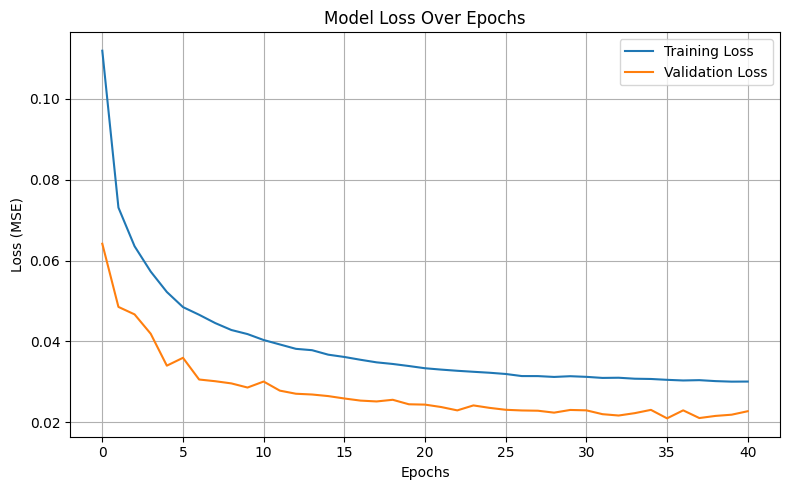

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:


# Get BROKEN event timestamps
broken_timestamps = df[df['machine_status'] == 'BROKEN'].index

# Prepare test sequences (only 2 hours before each BROKEN timestamp)
test_sequences = []
test_targets = []
test_times = []

advance_minutes = 120
sequence_length = 2

for ts in broken_timestamps:
    idx = df.index.get_loc(ts)

    if idx >= (advance_minutes + sequence_length):
        target_idx = idx - advance_minutes
        input_start = target_idx - sequence_length
        input_end = target_idx

        input_seq = df.iloc[input_start:input_end]
        target = df.iloc[target_idx]

        input_scaled = scaler.transform(input_seq[feature_cols])
        target_scaled = scaler.transform(target[feature_cols].values.reshape(1, -1))[0]

        test_sequences.append(input_scaled)
        test_targets.append(target_scaled)
        test_times.append(ts)  # actual failure time


X_test = np.array(test_sequences)
y_test = np.array(test_targets)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X h

In [43]:
# Predict and compute MSE
y_pred = model.predict(X_test)
mse = np.mean(np.power(y_test - y_pred, 2), axis=(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [44]:
threshold = 0.02
predictions = (mse > threshold).astype(int)

true_labels = np.ones(len(predictions))  # all test samples are pre-failure

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.86      0.92         7

    accuracy                           0.86         7
   macro avg       0.50      0.43      0.46         7
weighted avg       1.00      0.86      0.92         7

[[0 0]
 [1 6]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


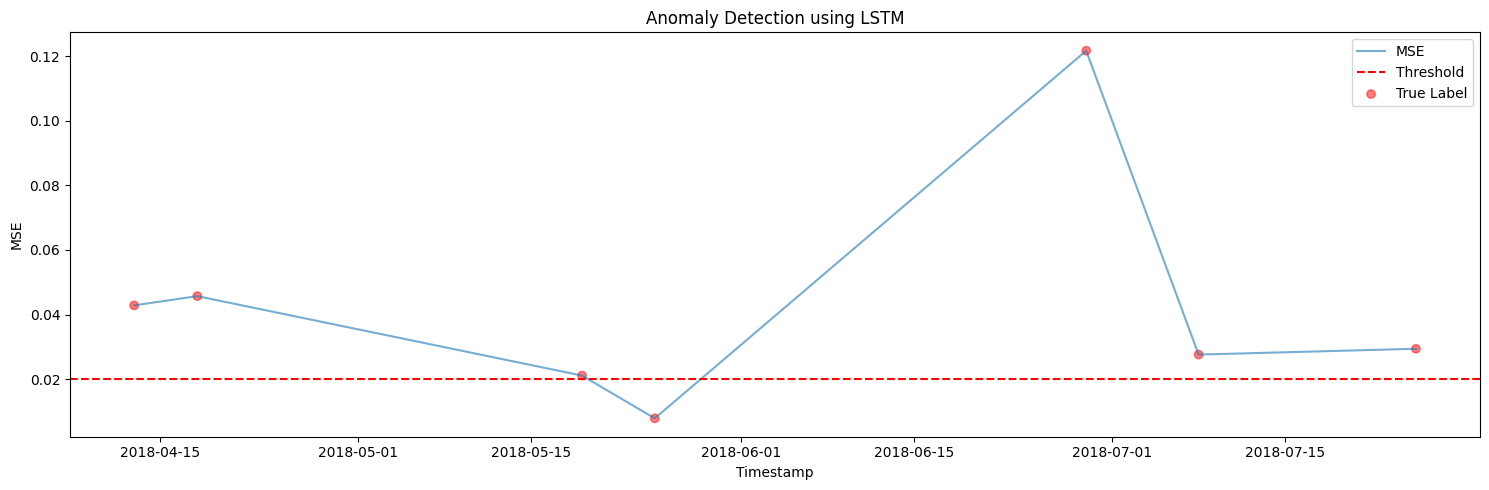

In [45]:
results = pd.DataFrame({
    'timestamp': test_times,
    'mse': mse,
    'true_label': true_labels,
    'predicted_anomaly': predictions
})

plt.figure(figsize=(15, 5))
plt.plot(results['timestamp'], results['mse'], label='MSE', alpha=0.6)
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Overlay labels
colors = results['true_label'].map({0: 'green', 1: 'red'})
plt.scatter(results['timestamp'], results['mse'], c=colors, alpha=0.5, label='True Label')

plt.title("Anomaly Detection using LSTM")
plt.xlabel("Timestamp")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()